# Meteorite's Impacts

In this dataset we will analyse a dataset about meteorites in order to make predictions about a future strike on our planet. More specifically, this dataset has been provided by NASA and contains recorded meteorite impacts on Earth. After exploring this dataset, we will predict the chance that, within 1000 years, a high-impact meteorite will strike Earth. Meteorite of high-impact is considered that of diameter greater than 1km.  

First, we will import all required packages as well as our dataset.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, skewnorm, lognorm

df = pd.read_csv("Meteorite_Landings.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass         45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45428 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


In [17]:
df.tail()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
45711,Zillah 002,31356,Valid,Eucrite,172.0,Found,1990.0,29.03700,17.01850,"(29.037000, 17.018500)"
45712,Zinder,30409,Valid,"Pallasite, ungrouped",46.0,Found,1999.0,13.78333,8.96667,"(13.783330, 8.966670)"
45713,Zlin,30410,Valid,H4,3.3,Found,1939.0,49.25000,17.66667,"(49.250000, 17.666670)"
45714,Zubkovsky,31357,Valid,L6,2167.0,Found,2003.0,49.78917,41.50460,"(49.789170, 41.504600)"
45715,Zulu Queen,30414,Valid,L3.7,200.0,Found,1976.0,33.98333,-115.68333,"(33.983330, -115.683330)"


## Investigate and explore Data

After having a first view of the dataset, we will remove all NaN values in order to make sure that the columns we want to work with all have sensible values.


In [18]:
df2 = df.dropna(subset=["mass", "year"])  # Remove NaN values
df2 = df2[df2["mass"] > 0]  # Zero mass impacts are also missing data

In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45292 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45292 non-null  object 
 1   id           45292 non-null  int64  
 2   nametype     45292 non-null  object 
 3   recclass     45292 non-null  object 
 4   mass         45292 non-null  float64
 5   fall         45292 non-null  object 
 6   year         45292 non-null  float64
 7   reclat       38097 non-null  float64
 8   reclong      38097 non-null  float64
 9   GeoLocation  38097 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.8+ MB


Let's also explore the data visually.

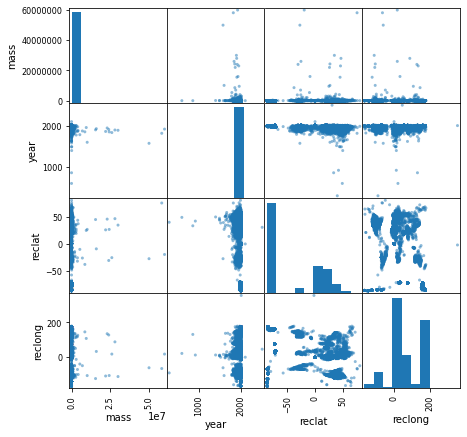

In [20]:
pd.plotting.scatter_matrix(df[["mass", "year", "reclat", "reclong"]], figsize=(7,7));

Now, mass is a positive value that spans many orders of magnitude, so it'll probably be easier to look at log mass instead of mass itself.

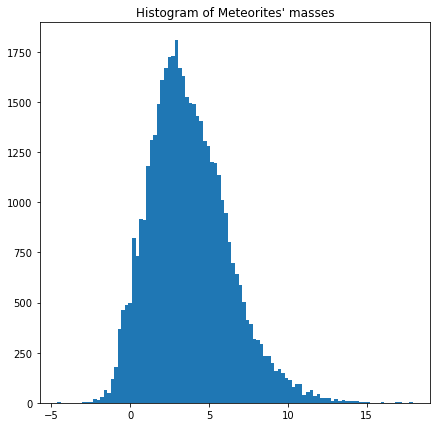

In [21]:
year = df2["year"]
masses = df2["mass"]
logmass = np.log(masses)

plt.figure(figsize=(7, 7));
plt.hist(logmass, bins=100);

plt.title('Histogram of Meteorites\' masses');

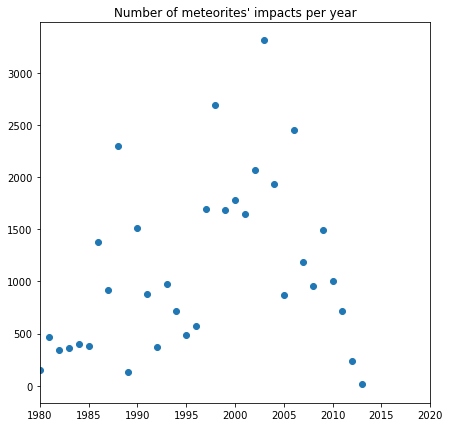

In [22]:
counts = year.value_counts()
plt.figure(figsize=(7, 7));
plt.scatter(counts.index, counts)
plt.xlim(1980, 2020);
plt.title('Number of meteorites\' impacts per year');

So, lets quantify our log-mass distribution from before. We can start and see if a normal works well.

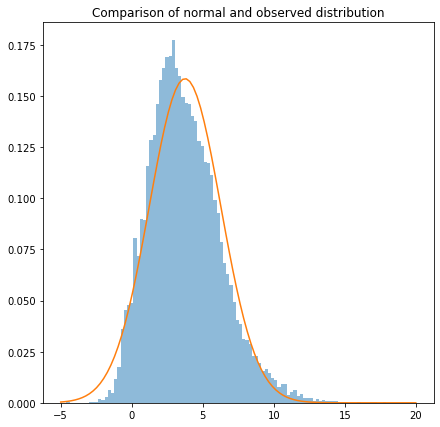

In [23]:
ms = np.linspace(-5, 20, 100)

mean, std = logmass.mean(), np.std(logmass)
pdf_norm = norm.pdf(ms, mean, std)
plt.figure(figsize=(7, 7));
plt.hist(logmass, bins=100, density=True, alpha=0.5)
plt.plot(ms, pdf_norm);
plt.title('Comparison of normal and observed distribution');

Not the best... Lets try both a skew-norm and a log-norm.

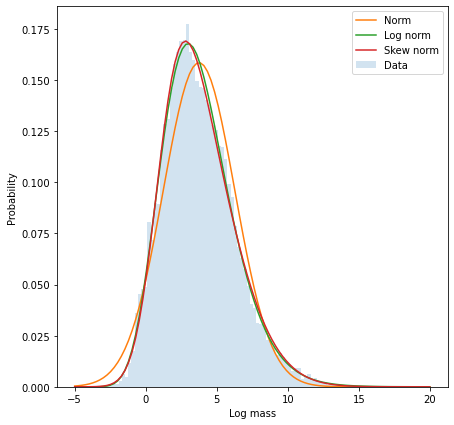

In [24]:
p_lognorm = lognorm.fit(logmass)
pdf_lognorm = lognorm.pdf(ms, *p_lognorm)

p_skewnorm = skewnorm.fit(logmass)
pdf_skewnorm = skewnorm.pdf(ms, *p_skewnorm)

plt.figure(figsize=(7, 7));
plt.hist(logmass, bins=100, density=True, alpha=0.2, label="Data")
plt.plot(ms, pdf_norm, label="Norm")
plt.plot(ms, pdf_lognorm, label="Log norm")
plt.plot(ms, pdf_skewnorm, label="Skew norm");
plt.legend()
plt.xlabel("Log mass")
plt.ylabel("Probability");

So either the log-norm or skew-norm looks like an adequate fit to the data. We want to extrapolate this distribution out to a mass we're concerned about - the mass of a 1km diameter meteor.

In [25]:
mass_of_doom = np.log((4/3) * np.pi * 500**3 * 1600 * 1000)  # Just using a spherical approximation and some avg density

So where does this value lie on our distribution. We'll go with the lognorm for now.

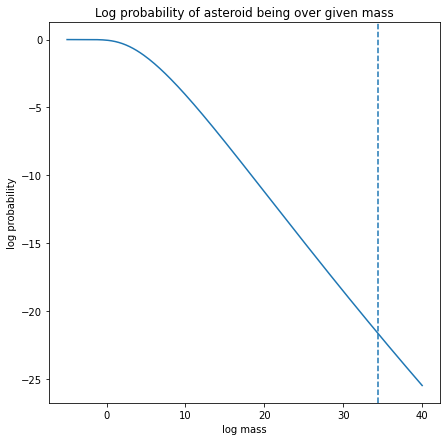

In [26]:
ms2 = np.linspace(-5, 40, 200)

plt.figure(figsize=(7, 7));
plt.plot(ms2, lognorm.logsf(ms2, *p_lognorm))
plt.axvline(mass_of_doom, ls="--")
plt.xlabel("log mass")
plt.ylabel("log probability")
plt.title("Log probability of asteroid being over given mass");

So we have here the probability of an asteroid being above a certain mass when it hits Earth. But to answer the question "What is the probability that one or more asteroids of high mass strike Earth in 1000 years?" we need to factor in the actual time component. Assume that in the next 1000 years, we predict to have $N$ impacts.

$$P(>=1\  {\rm highmass}) = 1 - P(0\ {\rm highmass}) = 1 - P(N\ {\rm not\_highmass}) = 1 - P({\rm not\_highmass})^N$$

So to give a number, we need to calculate $N$ from the yearly rate, number of years, and our detection efficiency and use that with the probability that any given impact is not high mass.

In [27]:
prob_small_mass = lognorm.logcdf(mass_of_doom, *p_lognorm)
frac_sky_monitored = 0.2
num_years = 1000
num_events = num_years * counts.max() / frac_sky_monitored
prob_bad = 1 - np.exp(num_events * prob_small_mass)
print(f"Probability that a >1km asteroid impacts with {num_years} years is {prob_bad * 100:.2f}%")

Probability that a >1km asteroid impacts with 1000 years is 0.67%


This means that, based on the used dataset, the probability that a meteorite of diameter greater than 1km will impact Earth within the next 1000 years with probability of 0.67%.